# Choropleth

`mapclassify` is intended to be used with visualization packages to handle the actual rendering of the choropleth maps defined on its classifiers. In this notebook, we explore some examples of how this is done. The notebook also includes an example that combines `mapclassify` with [ipywidgets](https://ipywidgets.readthedocs.io/en/latest/) to allow for the interactive exploration of the choice of:

- classification method
- number of classes
- colormap

In [1]:
import libpysal
import geopandas
import mapclassify
import matplotlib.pyplot as plt

mapclassify.__version__

'2.4.2+78.gc62d2d7.dirty'

The example in this notebook uses data on sudden death infant syndrome for counties in North Carolina. It is a built-in dataset  available through `libpysal`. We use `libpysal` to obtain the path to the shapefile and then use `geopandas` to create a geodataframe from the shapefile:

In [2]:
libpysal.examples.explain("sids2")

sids2
=====

North Carolina county SIDS death counts and rates
-------------------------------------------------

* sids2.dbf: attribute data. (k=18)
* sids2.html: metadata.
* sids2.shp: Polygon shapefile. (n=100)
* sids2.shx: spatial index.
* sids2.gal: spatial weights in GAL format.

Source: Cressie, Noel (1993). Statistics for Spatial Data. New York, Wiley, pp. 386-389. Rates computed.
Updated URL: https://geodacenter.github.io/data-and-lab/sids2/



In [3]:
pth = libpysal.examples.get_path("sids2.shp")
gdf = geopandas.read_file(pth)
gdf.head()

,AREA,PERIMETER,CNTY_,CNTY_ID,NAME,FIPS,FIPSNO,CRESS_ID,BIR74,SID74,NWBIR74,BIR79,SID79,NWBIR79,SIDR74,SIDR79,NWR74,NWR79,geometry
0,0.114,1.442,1825,1825,Ashe,37009,37009,5,1091.0,1.0,10.0,1364.0,0.0,19.0,0.916590,0.000000,9.165903,13.929619,"POLYGON ((-81.47276 36.23436, -81.54084 36.272..."
1,0.061,1.231,1827,1827,Alleghany,37005,37005,3,487.0,0.0,10.0,542.0,3.0,12.0,0.000000,5.535055,20.533881,22.140221,"POLYGON ((-81.23989 36.36536, -81.24069 36.379..."
2,0.143,1.630,1828,1828,Surry,37171,37171,86,3188.0,5.0,208.0,3616.0,6.0,260.0,1.568381,1.659292,65.244668,71.902655,"POLYGON ((-80.45634 36.24256, -80.47639 36.254..."
3,0.070,2.968,1831,1831,Currituck,37053,37053,27,508.0,1.0,123.0,830.0,2.0,145.0,1.968504,2.409639,242.125984,174.698795,"MULTIPOLYGON (((-76.00897 36.31960, -76.01735 ..."
4,0.153,2.206,1832,1832,Northampton,37131,37131,66,1421.0,9.0,1066.0,1606.0,3.0,1197.0,6.333568,1.867995,750.175932,745.330012,"POLYGON ((-77.21767 36.24098, -77.23461 36.214..."


Once created, the geodataframe has a `plot` method that can be called to create our first choropleth map. We will specify the column to classify and plot as `SIDR79`: SIDS death rate per 1,000 births (1979-84). The classification scheme is set to  `Quantiles`, and the number of classes set to `k=10` (declies):

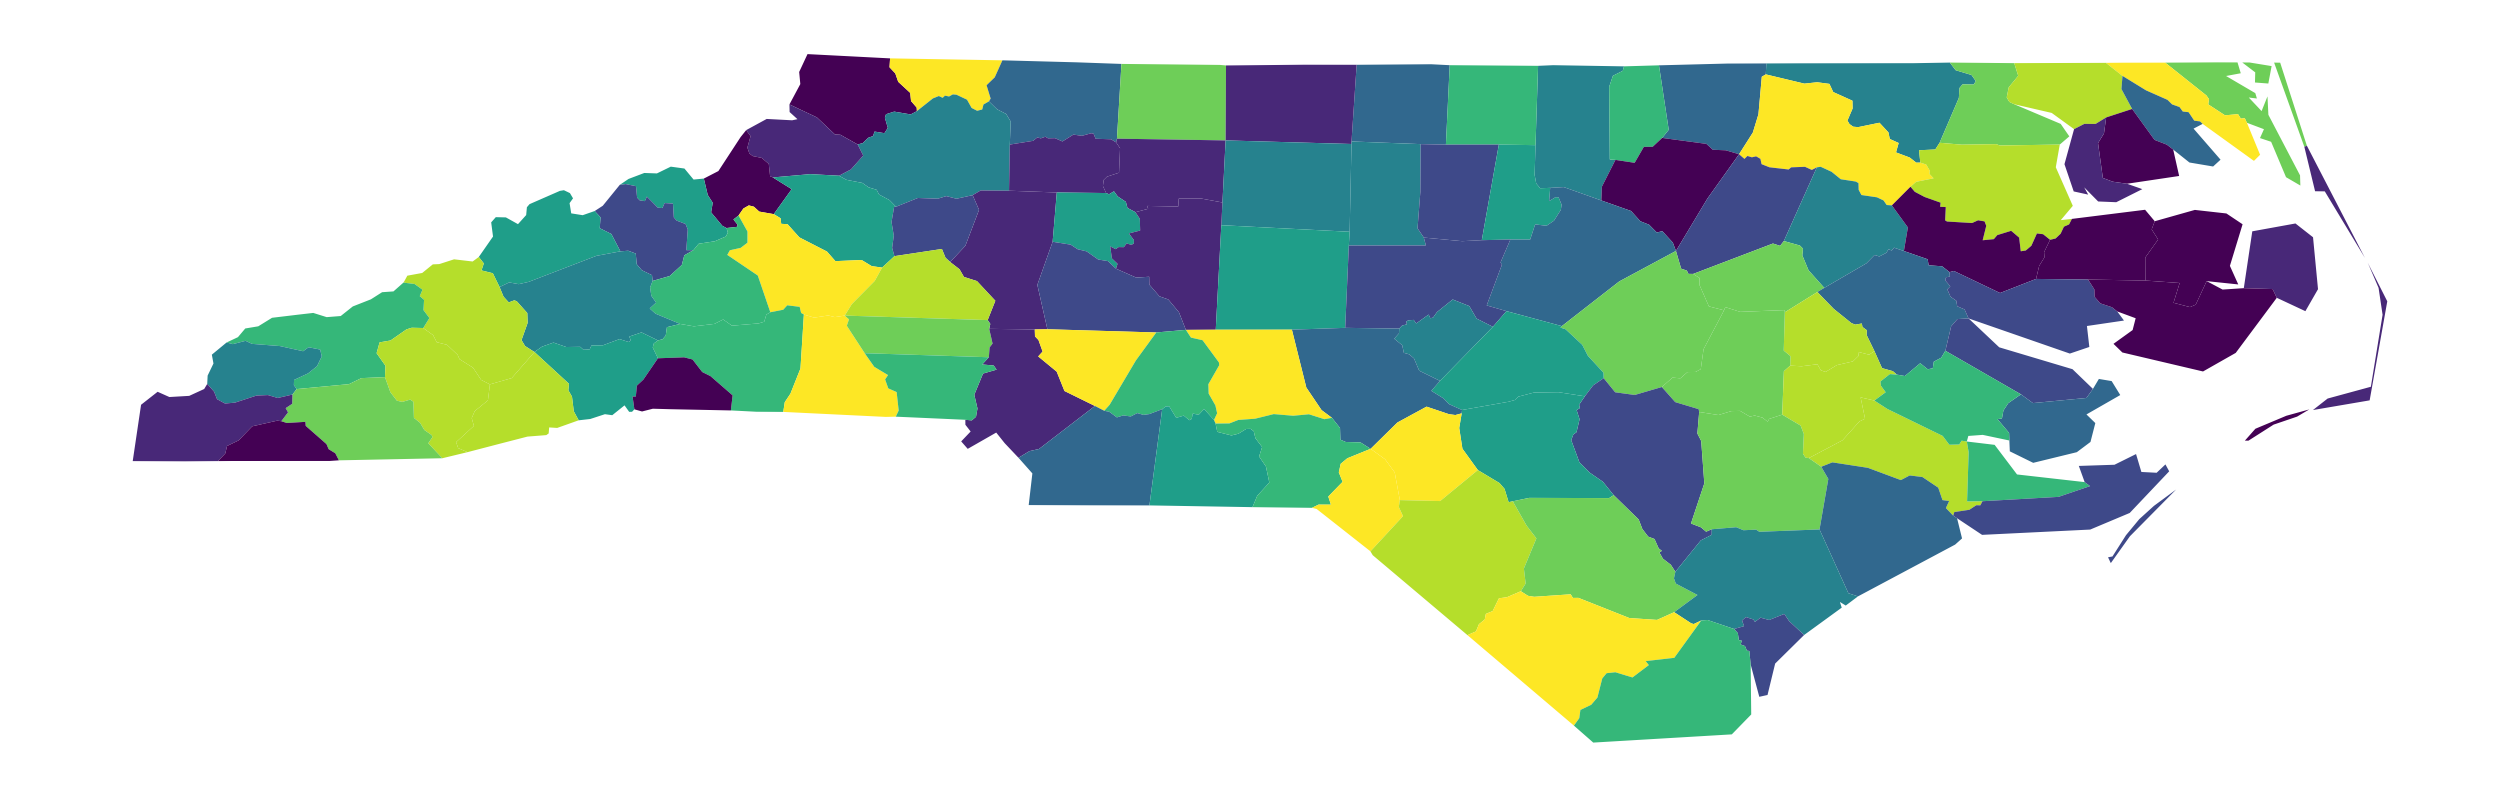

In [4]:
ax = gdf.plot(column="SIDR79", scheme="Quantiles", k=10, figsize=(16, 9))
ax.set_axis_off()

We can peak under the hood a bit and recreate the classification object that was used in the previous choropleth:

In [5]:
q10 = mapclassify.Quantiles(gdf.SIDR79, k=10)
q10

Quantiles

  Interval     Count
--------------------
[0.00, 0.56] |    10
(0.56, 1.15] |    10
(1.15, 1.40] |    10
(1.40, 1.79] |    10
(1.79, 2.08] |    10
(2.08, 2.18] |    10
(2.18, 2.38] |    10
(2.38, 2.81] |    10
(2.81, 3.40] |    10
(3.40, 6.11] |    10

For quick, exploratory work, the classifier object has its own `plot` method that takes a geodataframe as an argument:

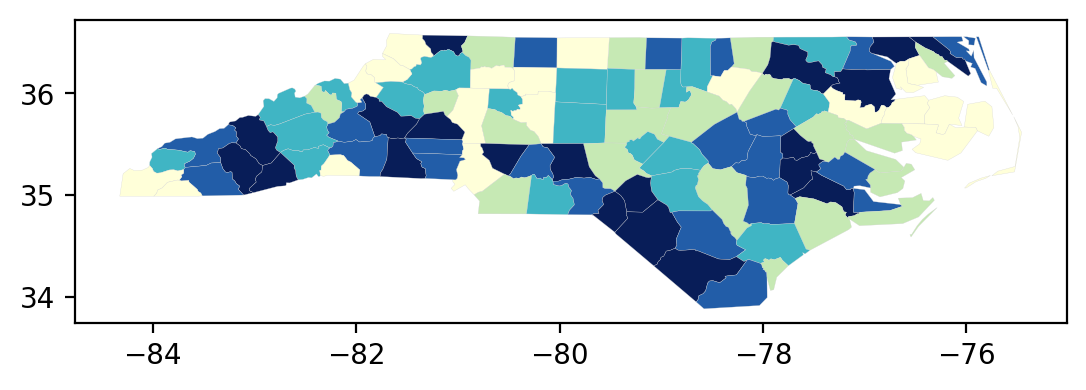

In [6]:
q10.plot(gdf);

Back to working directly with the dataframe, we can toggle on the `legend`:

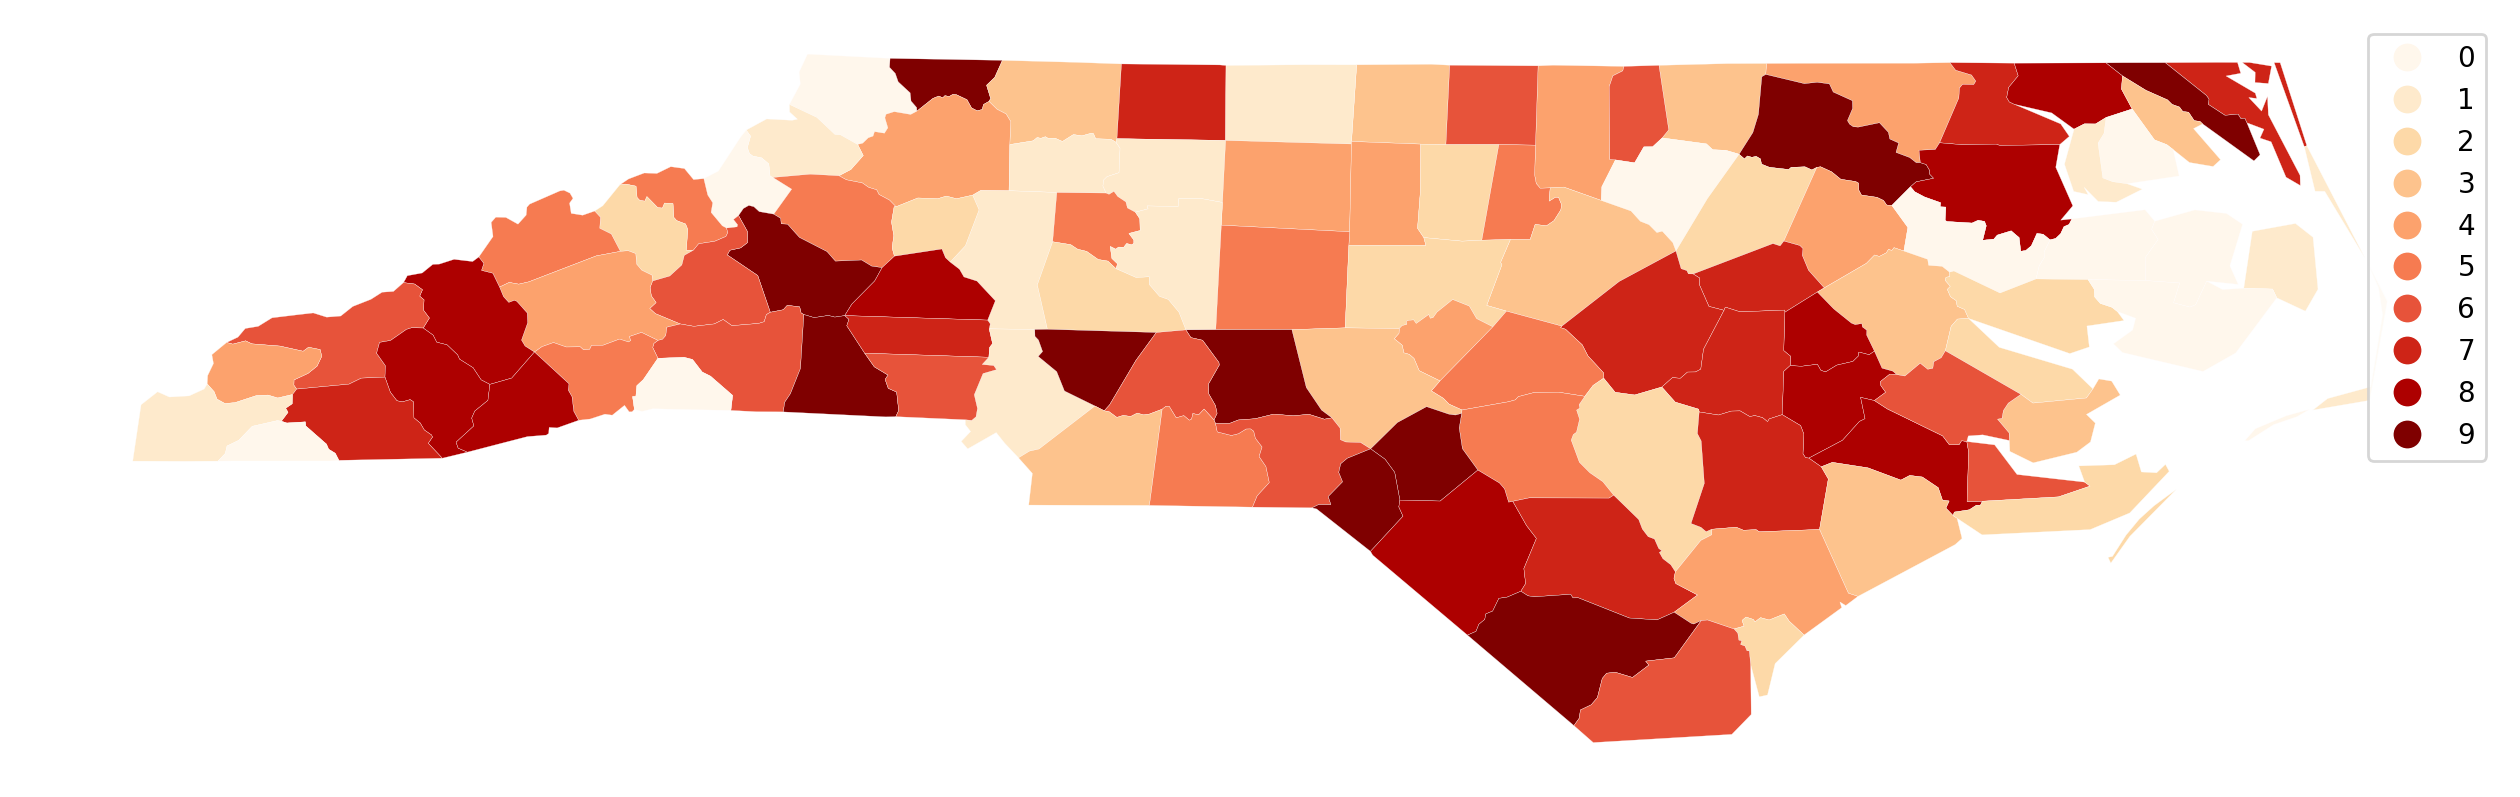

In [7]:
ax = gdf.assign(cl=q10.yb).plot(
    figsize=(16, 9),
    column="cl",
    categorical=True,
    k=10,
    cmap="OrRd",
    linewidth=0.1,
    edgecolor="white",
    legend=True,
)
ax.set_axis_off()

Here we see the 10 classes, but without more specific information on the legend, the user has to know that 0 is the first decile and 9 the 10th. We also do not know the values that define these classes. 

We can rectify this as follows:

In [8]:
q10.get_legend_classes()

['[0.00, 0.56]',
 '(0.56, 1.15]',
 '(1.15, 1.40]',
 '(1.40, 1.79]',
 '(1.79, 2.08]',
 '(2.08, 2.18]',
 '(2.18, 2.38]',
 '(2.38, 2.81]',
 '(2.81, 3.40]',
 '(3.40, 6.11]']

In [9]:
mapping = dict([(i, s) for i, s in enumerate(q10.get_legend_classes())])
mapping

{0: '[0.00, 0.56]',
 1: '(0.56, 1.15]',
 2: '(1.15, 1.40]',
 3: '(1.40, 1.79]',
 4: '(1.79, 2.08]',
 5: '(2.08, 2.18]',
 6: '(2.18, 2.38]',
 7: '(2.38, 2.81]',
 8: '(2.81, 3.40]',
 9: '(3.40, 6.11]'}

In [10]:
def replace_legend_items(legend, mapping):
    for txt in legend.texts:
        for k, v in mapping.items():
            if txt.get_text() == str(k):
                txt.set_text(v)

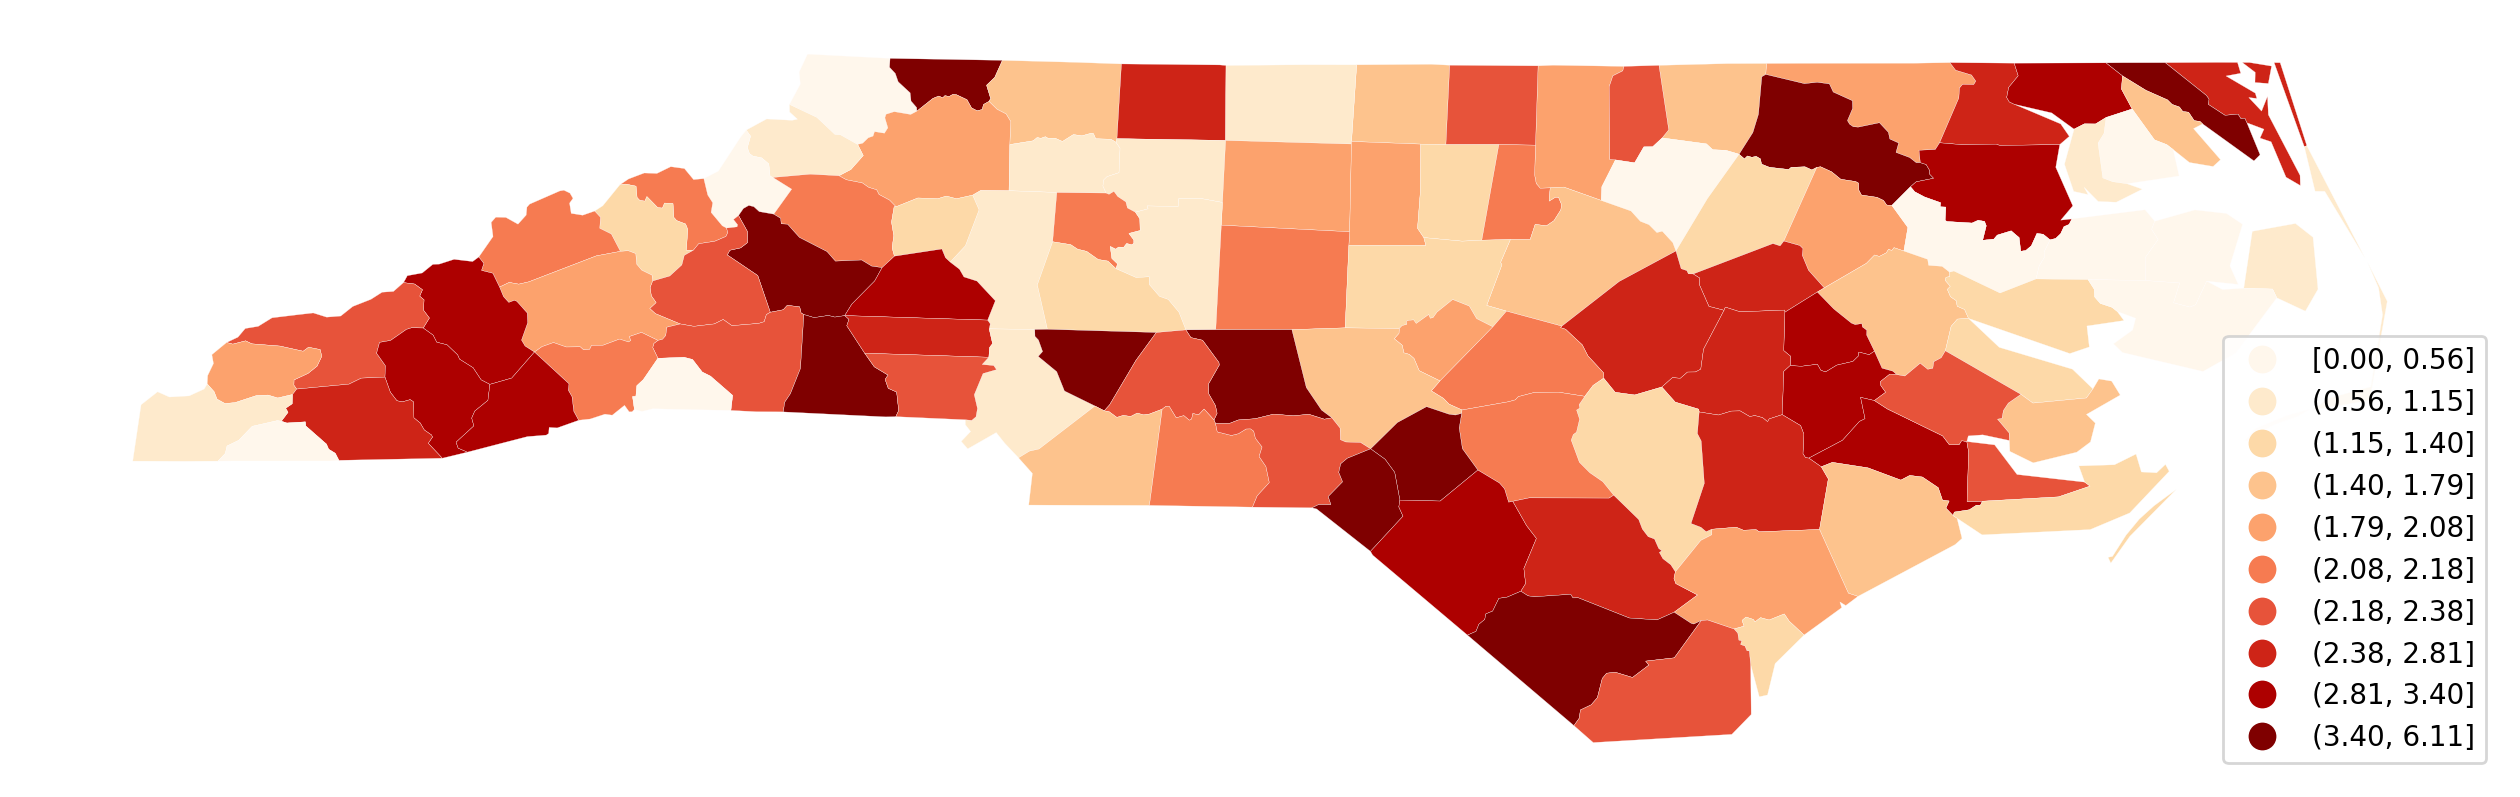

In [11]:
ax = gdf.assign(cl=q10.yb).plot(
    figsize=(16, 9),
    column="cl",
    categorical=True,
    k=10,
    cmap="OrRd",
    linewidth=0.1,
    edgecolor="white",
    legend=True,
    legend_kwds={"loc": "lower right"},
)
ax.set_axis_off()
replace_legend_items(ax.get_legend(), mapping)

## Interactive Exploration of Choropleth Classification

Next, we develop a small application that relies on `mapclassify` together with [palettable](https://jiffyclub.github.io/palettable/) and [ipywidgets](https://ipywidgets.readthedocs.io/en/latest/) to explore the choice of:

- classification method
- number of classes
- colormap



In [12]:
from ipywidgets import (
    interact,
    Button,
    Dropdown,
    FloatSlider,
    HBox,
    IntSlider,
    Label,
    Output,
    RadioButtons,
    Tab,
    VBox,  
)

from palettable import colorbrewer

Declare that our application shall have 3 options for color scheme...

In [13]:
data_type = RadioButtons(options=["Sequential", "Diverging", "Qualitative"])

... and define thise 3 colormaps based on [colorbrewer](https://colorbrewer2.org/#type=sequential&scheme=BuGn&n=3).

In [14]:
sequential = colorbrewer.COLOR_MAPS["Sequential"]
diverging = colorbrewer.COLOR_MAPS["Diverging"]
qualitative = colorbrewer.COLOR_MAPS["Qualitative"]

Next, create value and name options to bind the radio button to the dropdown menus...

In [15]:
bindings = {
    "Sequential": range(3, 9 + 1),
    "Diverging": range(3, 11 + 1),
    "Qualitative": range(3, 12 + 1),
}
cmap_bindings = {
    "Sequential": list(sequential.keys()),
    "Diverging": list(diverging.keys()),
    "Qualitative": list(qualitative.keys()),
}
class_val = Dropdown(options=bindings[data_type.value], value=5)
cmap_val = Dropdown(options=cmap_bindings[data_type.value])

... and define 7 `mapclassify` objects data classification. 

In [16]:
k_classifiers = {
    "equal_interval": mapclassify.EqualInterval,
    "fisher_jenks": mapclassify.FisherJenks,
    "jenks_caspall": mapclassify.JenksCaspall,
    "jenks_caspall_forced": mapclassify.JenksCaspallForced,
    "maximum_breaks": mapclassify.MaximumBreaks,
    "natural_breaks": mapclassify.NaturalBreaks,
    "quantiles": mapclassify.Quantiles,
}

Now it all together with helper functions for visualizing & updating plot options.

In [17]:
def k_values(ctype, cmap):
    k = list(colorbrewer.COLOR_MAPS[ctype][cmap].keys())
    return list(map(int, k))

def update_map(method="quantiles", k=5, cmap="Blues"):
    classifier = k_classifiers[method](gdf.SIDR79, k=k)
    mapping = dict([(i, s) for i, s in enumerate(classifier.get_legend_classes())])
    plt_kws = dict(figsize=(16, 9), column="cl", categorical=True, legend=True, lw=0.1)
    ax = gdf.assign(cl=classifier.yb).plot(
        k=k, cmap=cmap, ec="grey", legend_kwds={"loc": "lower left"}, **plt_kws
    )
    ax.set_axis_off()
    ax.set_title("SIDR79")
    replace_legend_items(ax.get_legend(), mapping)

def type_change(change):
    class_val.options = bindings[change["new"]]
    cmap_val.options = cmap_bindings[change["new"]]

def cmap_change(change):
    cmap = change["new"]
    ctype = data_type.value
    k = k_values(ctype, cmap)
    class_val.options = k

Finally, let's play with the interactive plot!
* *the plot will not render in the docs, but may be accessed directly by running this notebook locally or as a binder.*

In [18]:
data_type.observe(type_change, names=["value"])
cmap_val.observe(cmap_change, names=["value"])
out = Output()
Tab().children = [out]
interact(update_map, method=list(k_classifiers.keys()), cmap=cmap_val, k=class_val)
display(VBox([data_type, out]))

interactive(children=(Dropdown(description='method', index=6, options=('equal_interval', 'fisher_jenks', 'jenk…

Changing the type of colormap (sequential, diverging, qualitative) will update the options for the available color maps (`cmap`). Changing any of the values using the dropdowns will update the classification and the resulting choropleth map.

It is important to note that the example variable is best portrayed with the sequential colormaps. The other two types of colormaps are included for demonstration purposes only.